# Tech Product Evaluation System using LangGraph for Quantitative Scoring

In [2]:
from typing import List, Dict, Any, TypedDict, Annotated
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from operator import itemgetter
from langchain_openai import ChatOpenAI
import json

## Define the State Schema for ProductAnalysis & Comparison

In [3]:
# Define state schema
class ProductAnalysis(TypedDict):
    product: str
    evaluation: Dict[str, Dict[str, Any]]

class ComparisonState(TypedDict):
    products: List[str]
    criteria: List[str]
    weights: Dict[str, float]
    analysis: List[ProductAnalysis]
    scores: Dict[str, Any]
    current_product_index: int
    status: str

## Initialize the OpenAI LLM

In [4]:
llm = ChatOpenAI(model="gpt-4", temperature=0, top_p=1)

## Create the Nodes
### Analyze Product Node to fetch reviews from LLM

In [5]:
def analyze_product(state: ComparisonState) -> ComparisonState:
    products = state["products"]
    criteria = state["criteria"]
    weights = state["weights"]
    current_idx = state["current_product_index"]
    
    if current_idx >= len(products):
        state["status"] = "scoring"
        return state
    
    current_product = products[current_idx]
    
    analysis_prompt = f"""
    Analyze the following tech product: {current_product}
    Based on these criteria (with weights): {json.dumps(weights)}
    
    For each criterion:
    1. Provide detailed analysis
    2. Assign a score from 0-10
    3. Provide a confidence score (0-10) for your assessment based on:
       - Data availability
       - Market consensus
       - Technical specifications clarity
       - Your knowledge of the product category
    
    Format your response as JSON with this structure:
    {{
        "analysis": {{
            "criterion": {{
                "details": "analysis text",
                "score": numeric_score,
                "confidence": numeric_confidence_score,
                "confidence_reasoning": "explanation of confidence score"
            }}
        }}
    }}
    """
    
    response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis_result = json.loads(response.content)
    
    state["analysis"].append({
        "product": current_product,
        "evaluation": analysis_result["analysis"]
    })
    
    state["current_product_index"] += 1
    return state

### Calculate the Weighted Average Score from the LLM output along with Confidence Levels

In [6]:
def calculate_weighted_scores(state: ComparisonState) -> ComparisonState:
    scores = {}
    weights = state["weights"]
    total_weight = sum(weights.values())
    
    for analysis in state["analysis"]:
        product = analysis["product"]
        weighted_score = 0
        criterion_scores = {}
        confidence_scores = {}
        detailed_calculations = {}
        
        for criterion, details in analysis["evaluation"].items():
            criterion_weight = weights[criterion] / total_weight
            raw_score = details["score"]
            confidence = details["confidence"]
            
            criterion_scores[criterion] = raw_score
            confidence_scores[criterion] = confidence
            
            confidence_factor = confidence / 10
            adjusted_weight = criterion_weight * confidence_factor
            weighted_criterion_score = raw_score * adjusted_weight
            
            detailed_calculations[criterion] = {
                "raw_score": raw_score,
                "weight": criterion_weight,
                "confidence": confidence,
                "confidence_reasoning": details["confidence_reasoning"],
                "weighted_score": round(weighted_criterion_score, 2)
            }
            
            weighted_score += weighted_criterion_score
        
        normalized_score = weighted_score * (10 / total_weight)
        
        scores[product] = {
            "overall_score": round(normalized_score, 2),
            "raw_criterion_scores": criterion_scores,
            "confidence_scores": confidence_scores,
            "detailed_calculations": detailed_calculations,
            "average_confidence": round(sum(confidence_scores.values()) / len(confidence_scores), 2)
        }
    
    state["scores"] = scores
    state["status"] = "complete"
    return state

## Router to handle multiple Products and Scoring

In [7]:
def router(state: ComparisonState) -> str:
    if state["status"] == "scoring":
        return "calculate_scores"
    elif state["status"] == "complete":
        return END
    else:
        return "analyze_product"

## Build the Graph to allow moving through various Nodes

In [8]:
def create_comparison_graph() -> StateGraph:
    # Define the graph with state schema
    workflow = StateGraph(ComparisonState)
    
    # Add nodes
    workflow.add_node("analyze_product", analyze_product)
    workflow.add_node("calculate_scores", calculate_weighted_scores)
    
    # Add conditional edges using the router
    workflow.add_conditional_edges(
        "analyze_product",
        router,
        {
            "analyze_product": "analyze_product",
            "calculate_scores": "calculate_scores",
            END: END
        }
    )
    
    workflow.add_conditional_edges(
        "calculate_scores",
        router,
        {
            "analyze_product": "analyze_product",
            "calculate_scores": "calculate_scores",
            END: END
        }
    )
    
    # Set entry point
    workflow.set_entry_point("analyze_product")
    
    return workflow

## Putting it all together - Comparing the tech Products

In [9]:
def compare_tech_products(
    products: List[str], criteria_weights: Dict[str, float]) -> Dict[str, Any]:
    # Initialize state with proper typing
    initial_state: ComparisonState = {
        "products": products,
        "criteria": list(criteria_weights.keys()),
        "weights": criteria_weights,
        "analysis": [],
        "scores": {},
        "current_product_index": 0,
        "status": "initializing"
    }
    
    graph = create_comparison_graph()
    graph_app = graph.compile()
    # graph_app.validate()
    
    final_state = graph_app.invoke(initial_state)
    
    return final_state["scores"]

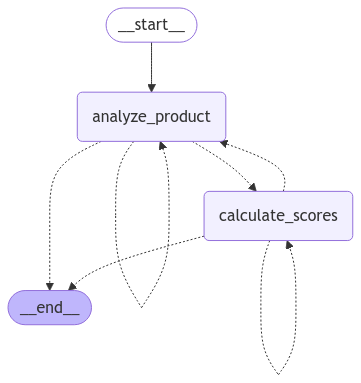

In [12]:
graph = create_comparison_graph()
graph_app = graph.compile()
graph_app.validate()

## Initiate the run & Display the results

In [9]:
if __name__ == "__main__":
    products = [
        "MacBook Pro M2",
        "Dell XPS 13",
        "Lenovo ThinkPad X1 Carbon"
    ]
    
    criteria_weights = {
        "Performance": 0.35,
        "Battery Life": 0.25,
        "Build Quality": 0.20,
        "Value for Money": 0.20
    }
    
    results = compare_tech_products(products, criteria_weights)
    print(json.dumps(results, indent=2))

{
  "MacBook Pro M2": {
    "overall_score": 65.2,
    "raw_criterion_scores": {
      "Performance": 9,
      "Battery Life": 8,
      "Build Quality": 9,
      "Value for Money": 7
    },
    "confidence_scores": {
      "Performance": 8,
      "Battery Life": 7,
      "Build Quality": 9,
      "Value for Money": 7
    },
    "detailed_calculations": {
      "Performance": {
        "raw_score": 9,
        "weight": 0.35,
        "confidence": 8,
        "confidence_reasoning": "While the exact specifications of the M2 chip are not yet known, the performance of the M1 chip and Apple's track record of improving performance with each new chip generation provide a strong basis for this assessment.",
        "weighted_score": 2.52
      },
      "Battery Life": {
        "raw_score": 8,
        "weight": 0.25,
        "confidence": 7,
        "confidence_reasoning": "While the exact battery life of the M2 MacBook Pro is not yet known, the battery life of the M1 MacBook Pro and the power 